## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == 

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [3]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [5]:
from transformers import SegformerImageProcessor

root_dir = '/kaggle/working/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

2025-09-09 04:19:55.995598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757391596.185383      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757391596.238736      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [9]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [10]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [13]:
batch = next(iter(train_dataloader))

In [14]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [15]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [16]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True, False, False],
         [False,  True,  True,  ...,  True, False, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [17]:
batch["labels"][mask]

tensor([5, 5, 5,  ..., 3, 3, 3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [18]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

ade20k-id2label.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [19]:
import evaluate

metric = evaluate.load("mean_iou")

In [20]:
image_processor.do_reduce_labels

True

In [21]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.064998626708984
Mean_iou: 5.4054034407921493e-05
Mean accuracy: 0.0007768703367667877
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.9229350090026855
Mean_iou: 0.0037803090941517844
Mean accuracy: 0.06590368470980963
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.657482147216797
Mean_iou: 0.014743000277289585
Mean accuracy: 0.21110065846762313
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.462193489074707
Mean_iou: 0.02289447413033743
Mean accuracy: 0.36157956765353466
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.431294918060303
Mean_iou: 0.022934241081118436
Mean accuracy: 0.30240054504835584
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.312092304229736
Mean_iou: 0.03643927643344527
Mean accuracy: 0.155584318040747
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.0693278312683105
Mean_iou: 0.06639127162478317
Mean accuracy: 0.2668621983850187
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.31938362121582
Mean_iou: 0.039080816512728156
Mean accuracy: 0.4774548158709403
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.924989938735962
Mean_iou: 0.03448788162867589
Mean accuracy: 0.1540357177415546
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.923840045928955
Mean_iou: 0.06629576910729314
Mean accuracy: 0.3014890549952407
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.4391543865203857
Mean_iou: 0.25136712952967083
Mean accuracy: 0.5039270350835985
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3615920543670654
Mean_iou: 0.08314037583593709
Mean accuracy: 0.20214488531488603
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.209737539291382
Mean_iou: 0.13995371178163357
Mean accuracy: 0.28595024251474094
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.319789171218872
Mean_iou: 0.13317893783781146
Mean accuracy: 0.340977467679846
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.054387331008911
Mean_iou: 0.11562148510824061
Mean accuracy: 0.3150038987126124
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8865396976470947
Mean_iou: 0.11880178554086403
Mean accuracy: 0.2626244403412657
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.1877200603485107
Mean_iou: 0.20388530507724653
Mean accuracy: 0.3091756860797621
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2103474140167236
Mean_iou: 0.2679378786044023
Mean accuracy: 0.4961022008546217
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9215810298919678
Mean_iou: 0.16313181581116468
Mean accuracy: 0.29452041840802334
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9412758350372314
Mean_iou: 0.29813666740193
Mean accuracy: 0.5101723633016926
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8392093181610107
Mean_iou: 0.16430185234267808
Mean accuracy: 0.25788877834051066
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.283076524734497
Mean_iou: 0.2108214337760157
Mean accuracy: 0.4104022428854512
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.709920644760132
Mean_iou: 0.34937391810004403
Mean accuracy: 0.49814524571809454
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5259861946105957
Mean_iou: 0.3168282785661223
Mean accuracy: 0.43944279331054786
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6612441539764404
Mean_iou: 0.3219336720231622
Mean accuracy: 0.48896795431673584
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3899478912353516
Mean_iou: 0.10578534496181584
Mean accuracy: 0.17333753054660872
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.286330223083496
Mean_iou: 0.27442275718357106
Mean accuracy: 0.5417572478656656
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4173829555511475
Mean_iou: 0.34652200130158956
Mean accuracy: 0.6899175545169767
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.345705270767212
Mean_iou: 0.3699446860814988
Mean accuracy: 0.5241816754731817
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2246644496917725
Mean_iou: 0.5150369095339574
Mean accuracy: 0.573566056455105
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.4137327671051025
Mean_iou: 0.40542658535183
Mean accuracy: 0.5653842075562674
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3459463119506836
Mean_iou: 0.1939676687420104
Mean accuracy: 0.3744106738622684
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3957208395004272
Mean_iou: 0.34866871032422986
Mean accuracy: 0.5064418031082097
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.072530746459961
Mean_iou: 0.1585344571143436
Mean accuracy: 0.22523930305489137
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.765212059020996
Mean_iou: 0.17652224255955604
Mean accuracy: 0.27919236972883843
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.14983868598938
Mean_iou: 0.3661754763281683
Mean accuracy: 0.45457639683674766
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0808351039886475
Mean_iou: 0.45486113157907865
Mean accuracy: 0.5619778005349206
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.026432752609253
Mean_iou: 0.2871073701887077
Mean accuracy: 0.4658887804024458
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0234410762786865
Mean_iou: 0.31170407322311733
Mean accuracy: 0.4600997914378312
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0485644340515137
Mean_iou: 0.3455555711348751
Mean accuracy: 0.5368155918228095
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9841020107269287
Mean_iou: 0.2519952697758285
Mean accuracy: 0.3288522384655479
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0761932134628296
Mean_iou: 0.37958490595083827
Mean accuracy: 0.5114685653123062
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1508065462112427
Mean_iou: 0.30482818287805796
Mean accuracy: 0.5163280228255617
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7157872915267944
Mean_iou: 0.4867167707674119
Mean accuracy: 0.6362642382994195
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.585361123085022
Mean_iou: 0.22307658932238356
Mean accuracy: 0.3182370221093277
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4365142583847046
Mean_iou: 0.41663510920464203
Mean accuracy: 0.5152197580097884
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.514269232749939
Mean_iou: 0.5957182229134274
Mean accuracy: 0.7858572937496082
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5662157535552979
Mean_iou: 0.2203193394019887
Mean accuracy: 0.3652665822207296
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2894245386123657
Mean_iou: 0.2943112247051972
Mean accuracy: 0.4039459664135213
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6488096714019775
Mean_iou: 0.32820596183902795
Mean accuracy: 0.4846423280869798
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5979585647583008
Mean_iou: 0.4302190217163034
Mean accuracy: 0.6101321607511895
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4997951984405518
Mean_iou: 0.1975154729346152
Mean accuracy: 0.25779050747717164
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4949103593826294
Mean_iou: 0.2031601194687707
Mean accuracy: 0.3356425509641749
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.578361988067627
Mean_iou: 0.17080487115251178
Mean accuracy: 0.24197346493257024
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3078267574310303
Mean_iou: 0.456984532600407
Mean accuracy: 0.530175236799223
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3634757995605469
Mean_iou: 0.5902203987354606
Mean accuracy: 0.8355021418688194
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4635647535324097
Mean_iou: 0.1690287660537444
Mean accuracy: 0.23209172341382794
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0437272787094116
Mean_iou: 0.19715691992667883
Mean accuracy: 0.28309863299259364
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.364851951599121
Mean_iou: 0.44127231833898195
Mean accuracy: 0.5663848818991738
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.998244047164917
Mean_iou: 0.536102538777375
Mean accuracy: 0.6742514218965886
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1460061073303223
Mean_iou: 0.19728228441449835
Mean accuracy: 0.27102600164140983
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1659774780273438
Mean_iou: 0.25989392630127667
Mean accuracy: 0.322068635360655
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2494938373565674
Mean_iou: 0.31659114338411604
Mean accuracy: 0.44530393943937846
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0920881032943726
Mean_iou: 0.2874758614244967
Mean accuracy: 0.4139213142775601
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8273136615753174
Mean_iou: 0.3553999514338456
Mean accuracy: 0.5477437731610473
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1985149383544922
Mean_iou: 0.5017143589350146
Mean accuracy: 0.6543679989467199
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1642322540283203
Mean_iou: 0.17339295889823525
Mean accuracy: 0.31697787276154404
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3548445999622345
Mean_iou: 0.436087292791971
Mean accuracy: 0.6150342219124363
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.312859296798706
Mean_iou: 0.40017712676415673
Mean accuracy: 0.5022646129037643
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5813046097755432
Mean_iou: 0.40705209479619014
Mean accuracy: 0.5450237907029188
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3119615316390991
Mean_iou: 0.43101809386439943
Mean accuracy: 0.5991549402471897
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.144553303718567
Mean_iou: 0.3192029480167748
Mean accuracy: 0.43135790561725185
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6658670902252197
Mean_iou: 0.4755151398525644
Mean accuracy: 0.5721868272929094
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2425976991653442
Mean_iou: 0.5118163562144712
Mean accuracy: 0.6423132040580777
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2560369968414307
Mean_iou: 0.3154892213280365
Mean accuracy: 0.3894138718055338
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.992180347442627
Mean_iou: 0.2251719081724199
Mean accuracy: 0.327815386860012
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0755809545516968
Mean_iou: 0.31017385190536567
Mean accuracy: 0.4394010885716417
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4006878137588501
Mean_iou: 0.6570762518635391
Mean accuracy: 0.8462672953376404
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.13432776927948
Mean_iou: 0.2208103697477215
Mean accuracy: 0.3783807115509275
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7445974946022034
Mean_iou: 0.4144511564757182
Mean accuracy: 0.6572658889570677
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9634220004081726
Mean_iou: 0.5121610827672705
Mean accuracy: 0.5933129863844141
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8256113529205322
Mean_iou: 0.4515611976678274
Mean accuracy: 0.7159113600415911
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9848425388336182
Mean_iou: 0.46989116711345236
Mean accuracy: 0.6353548559495105
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.831986129283905
Mean_iou: 0.7352379598464739
Mean accuracy: 0.8701111656754918
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4483243525028229
Mean_iou: 0.7656725751796319
Mean accuracy: 0.7900039159172687
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.139387607574463
Mean_iou: 0.2926853944462166
Mean accuracy: 0.37036839989500614
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9813739657402039
Mean_iou: 0.25758073780849455
Mean accuracy: 0.3631644874971708
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.733576238155365
Mean_iou: 0.5398344627164348
Mean accuracy: 0.7116346803242347
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8739718794822693
Mean_iou: 0.4283382427019184
Mean accuracy: 0.5136714865541185
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7444353699684143
Mean_iou: 0.1280250812899769
Mean accuracy: 0.20964246184319152
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.549627959728241
Mean_iou: 0.4666039291086496
Mean accuracy: 0.5880334459812797
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2704813778400421
Mean_iou: 0.32059542107608596
Mean accuracy: 0.6165022178603191
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9457173943519592
Mean_iou: 0.305664726046233
Mean accuracy: 0.44913544324442367
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9676254391670227
Mean_iou: 0.3359431307841731
Mean accuracy: 0.518255338637633
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0784146785736084
Mean_iou: 0.285944304699693
Mean accuracy: 0.3659363631864345
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7293471097946167
Mean_iou: 0.6461731895222758
Mean accuracy: 0.6933140978558798
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6121436953544617
Mean_iou: 0.3499087556620474
Mean accuracy: 0.46702471741558305
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9555464386940002
Mean_iou: 0.355832027785039
Mean accuracy: 0.5173251982723408
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8030475378036499
Mean_iou: 0.3429052198710587
Mean accuracy: 0.4600099823452166
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7622895836830139
Mean_iou: 0.28068567306026376
Mean accuracy: 0.38701121728503796
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7165493965148926
Mean_iou: 0.2135978191107581
Mean accuracy: 0.3206003018838431
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8038290143013
Mean_iou: 0.3217705202552034
Mean accuracy: 0.45022014418697454
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9790866374969482
Mean_iou: 0.23924361345812886
Mean accuracy: 0.3152488211902271
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7985692024230957
Mean_iou: 0.4086507445392485
Mean accuracy: 0.5378868367710833
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45931488275527954
Mean_iou: 0.377856183099598
Mean accuracy: 0.541491729326552
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8564450144767761
Mean_iou: 0.46907004961855786
Mean accuracy: 0.550119325470695
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.805273711681366
Mean_iou: 0.28135225237737765
Mean accuracy: 0.40278633177205964
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5686362981796265
Mean_iou: 0.4969255185268272
Mean accuracy: 0.5298532844675092
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4183402955532074
Mean_iou: 0.3700236328481194
Mean accuracy: 0.6074975212223328
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8980447053909302
Mean_iou: 0.33359029879260343
Mean accuracy: 0.4055385627871109
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7829315066337585
Mean_iou: 0.32796017988933757
Mean accuracy: 0.4863787289482482
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9133705496788025
Mean_iou: 0.4330022727513244
Mean accuracy: 0.6190561820500354
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5562581419944763
Mean_iou: 0.5466005754492826
Mean accuracy: 0.7147958891364283
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37431079149246216
Mean_iou: 0.6324644985537895
Mean accuracy: 0.6671390077603683
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8888357877731323
Mean_iou: 0.3183650968018493
Mean accuracy: 0.41444738549084226
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5550265908241272
Mean_iou: 0.48370546684969473
Mean accuracy: 0.5913615753525202
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32974138855934143
Mean_iou: 0.7322132576554838
Mean accuracy: 0.8638872151614814
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19669608771800995
Mean_iou: 0.574827691526858
Mean accuracy: 0.6631267899240498
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.631771981716156
Mean_iou: 0.6308552988918065
Mean accuracy: 0.6623941667619706
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.378701388835907
Mean_iou: 0.5114835727932304
Mean accuracy: 0.7474955788920435
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7580631971359253
Mean_iou: 0.5112877220002932
Mean accuracy: 0.651267930402436
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6325757503509521
Mean_iou: 0.357246493656149
Mean accuracy: 0.4887682738388932
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4668021500110626
Mean_iou: 0.8241534317861265
Mean accuracy: 0.8622103017276842
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6382337808609009
Mean_iou: 0.38618269501331826
Mean accuracy: 0.5231251196836378
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.415208101272583
Mean_iou: 0.4777778795740011
Mean accuracy: 0.7490418514432216
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3652883470058441
Mean_iou: 0.6284246422375529
Mean accuracy: 0.6594636234027804
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4877968430519104
Mean_iou: 0.7482692394551006
Mean accuracy: 0.7995544451241119
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6147230267524719
Mean_iou: 0.31126391350624844
Mean accuracy: 0.43262663768127874
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5936428904533386
Mean_iou: 0.24935660856915784
Mean accuracy: 0.33684035391561656
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6377838850021362
Mean_iou: 0.5585285099166926
Mean accuracy: 0.5946220614989122
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8300275206565857
Mean_iou: 0.3654225788607246
Mean accuracy: 0.420949883069854
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6214911937713623
Mean_iou: 0.36754939726776853
Mean accuracy: 0.4975689689070785
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7954664826393127
Mean_iou: 0.20707813124478136
Mean accuracy: 0.3010056674825957
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.530447244644165
Mean_iou: 0.5939507328431481
Mean accuracy: 0.6286438053269893
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3003677725791931
Mean_iou: 0.40261432451392537
Mean accuracy: 0.6896009857409858
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5416615009307861
Mean_iou: 0.42114827983625325
Mean accuracy: 0.5226696009968675
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.47619691491127014
Mean_iou: 0.7214639260073866
Mean accuracy: 0.7672695435178434
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4773518145084381
Mean_iou: 0.5815134052400659
Mean accuracy: 0.6994976746765122
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.30419495701789856
Mean_iou: 0.6651657185743263
Mean accuracy: 0.6962504866143215
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12541459500789642
Mean_iou: 0.5073870049646493
Mean accuracy: 0.7079766008441922
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5503345131874084
Mean_iou: 0.47797422511878046
Mean accuracy: 0.5627871524084067
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.43401768803596497
Mean_iou: 0.4266597699086534
Mean accuracy: 0.5555173805632351
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4635094404220581
Mean_iou: 0.6153681823679734
Mean accuracy: 0.6965271511961809
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.646865725517273
Mean_iou: 0.3688170339889534
Mean accuracy: 0.46606501104892895
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.50222247838974
Mean_iou: 0.7042990626256302
Mean accuracy: 0.7486133546389784
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7366400957107544
Mean_iou: 0.23151965129577062
Mean accuracy: 0.31665833480775146
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2625499963760376
Mean_iou: 0.49563755225271594
Mean accuracy: 0.7056766870845894
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11882629245519638
Mean_iou: 0.4731239226452422
Mean accuracy: 0.7197106294454665
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6027302145957947
Mean_iou: 0.337930058420132
Mean accuracy: 0.37974996279059686
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4899509847164154
Mean_iou: 0.4189221253695869
Mean accuracy: 0.5607943315353463
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5421209931373596
Mean_iou: 0.4372083401322601
Mean accuracy: 0.5124279433295715
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.647221028804779
Mean_iou: 0.3898821693711236
Mean accuracy: 0.45622489100917696
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4648277163505554
Mean_iou: 0.6949308301601372
Mean accuracy: 0.8805819414573914
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4080347418785095
Mean_iou: 0.33707136348035766
Mean accuracy: 0.507044937250958
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34186577796936035
Mean_iou: 0.5249117228513053
Mean accuracy: 0.5914408448554611
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4642101526260376
Mean_iou: 0.40403055622637934
Mean accuracy: 0.4948562723964275
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6019821763038635
Mean_iou: 0.41825050232817523
Mean accuracy: 0.5009149590989147
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4294564425945282
Mean_iou: 0.20516398035813857
Mean accuracy: 0.3281596119730171
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4224550724029541
Mean_iou: 0.7270071856202365
Mean accuracy: 0.7617571727699124
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5207614898681641
Mean_iou: 0.6372420331287343
Mean accuracy: 0.6662011291065575
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3730727732181549
Mean_iou: 0.6624631415912464
Mean accuracy: 0.6984191983113422
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28950467705726624
Mean_iou: 0.4471634343563439
Mean accuracy: 0.6113391869499638
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4230761229991913
Mean_iou: 0.334067415791173
Mean accuracy: 0.39844061931385577
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6041152477264404
Mean_iou: 0.34029652554812573
Mean accuracy: 0.3834995776579555
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.611233115196228
Mean_iou: 0.44230587645273106
Mean accuracy: 0.6159408051968442
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27819469571113586
Mean_iou: 0.4471151698928175
Mean accuracy: 0.608653825811643
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3363168239593506
Mean_iou: 0.8257516320607875
Mean accuracy: 0.8774193623114733
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44200506806373596
Mean_iou: 0.49895883509110106
Mean accuracy: 0.5774065092061851
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2684541940689087
Mean_iou: 0.8314835392102492
Mean accuracy: 0.8645040920137842
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.10999177396297455
Mean_iou: 0.846388879412328
Mean accuracy: 0.8601396988622445
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.536423921585083
Mean_iou: 0.538238039350181
Mean accuracy: 0.6280938681414552
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5032300353050232
Mean_iou: 0.2642555387424944
Mean accuracy: 0.36591950874330725
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3201664984226227
Mean_iou: 0.30265423694832216
Mean accuracy: 0.544839602279749
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3681098222732544
Mean_iou: 0.658750081080335
Mean accuracy: 0.6899993991899986
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3974588215351105
Mean_iou: 0.5662244438037847
Mean accuracy: 0.6873312560914858
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4953567385673523
Mean_iou: 0.5219172132409251
Mean accuracy: 0.5691729123404344
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.345234215259552
Mean_iou: 0.7351825500260859
Mean accuracy: 0.7542482362524863
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48120248317718506
Mean_iou: 0.43791346477567344
Mean accuracy: 0.5668308360098108
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4396769106388092
Mean_iou: 0.4914557379387728
Mean accuracy: 0.5748120413129941
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39915409684181213
Mean_iou: 0.359357705550276
Mean accuracy: 0.4477328815323647
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3236057460308075
Mean_iou: 0.6785037891136912
Mean accuracy: 0.7102460729423212
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3173161745071411
Mean_iou: 0.7345121242434701
Mean accuracy: 0.7538028244083321
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1715128868818283
Mean_iou: 0.44036054379849826
Mean accuracy: 0.7483320368752744
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3905332088470459
Mean_iou: 0.3703866021450874
Mean accuracy: 0.44933274447499116
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21438953280448914
Mean_iou: 0.46124334043390874
Mean accuracy: 0.6908356313015785
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18855752050876617
Mean_iou: 0.5349674482134607
Mean accuracy: 0.7801796381350782
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2349618822336197
Mean_iou: 0.7685051381496363
Mean accuracy: 0.8842175444501472
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4010845124721527
Mean_iou: 0.5361161448400168
Mean accuracy: 0.6583432978097109
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.07165108621120453
Mean_iou: 0.4849557425311874
Mean accuracy: 0.734473580385
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3203005790710449
Mean_iou: 0.7498957470166948
Mean accuracy: 0.7904172463639094
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2264033704996109
Mean_iou: 0.422347996212404
Mean accuracy: 0.6246435329787564
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27399295568466187
Mean_iou: 0.8318527826260288
Mean accuracy: 0.8814713777694247
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31251877546310425
Mean_iou: 0.6807075989609015
Mean accuracy: 0.7161353745923553
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2886868119239807
Mean_iou: 0.7655560092231155
Mean accuracy: 0.7855449630091964
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4005300998687744
Mean_iou: 0.5598290260260279
Mean accuracy: 0.6062412274344932
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4156724512577057
Mean_iou: 0.5311835869067241
Mean accuracy: 0.5751615441979866
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36440232396125793
Mean_iou: 0.37714891210307855
Mean accuracy: 0.4319276840659879
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.40373703837394714
Mean_iou: 0.6318547466850343
Mean accuracy: 0.6612045720741258
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.41670235991477966
Mean_iou: 0.37556335333618474
Mean accuracy: 0.4505286458052226
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3403078615665436
Mean_iou: 0.36187960962098487
Mean accuracy: 0.4281974272756188


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

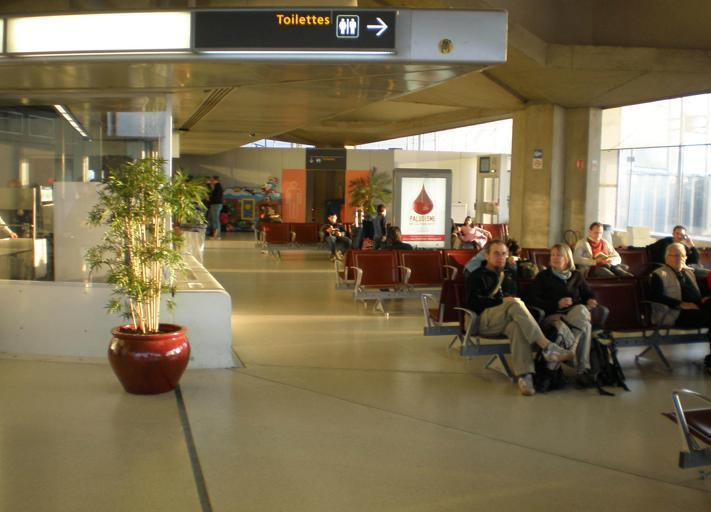

In [23]:
image = Image.open('/kaggle/working/ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg')
image

In [24]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [25]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [26]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [27]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [28]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


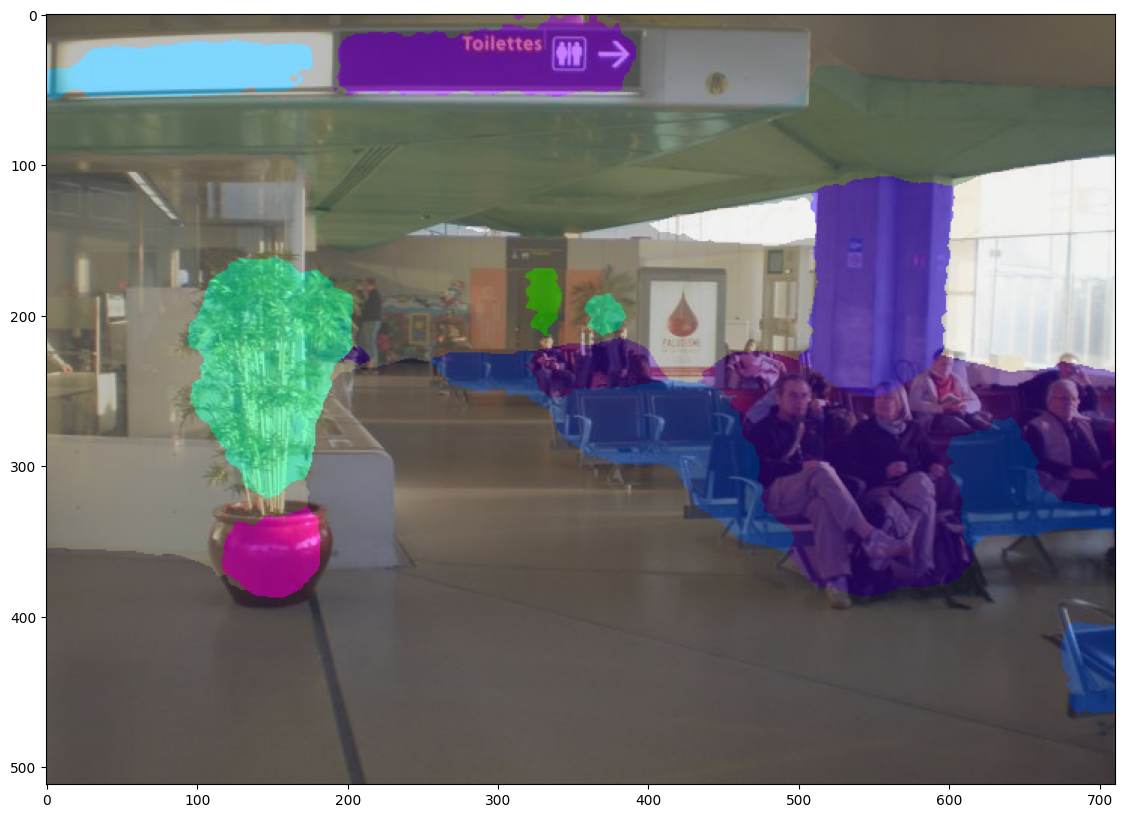

In [29]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

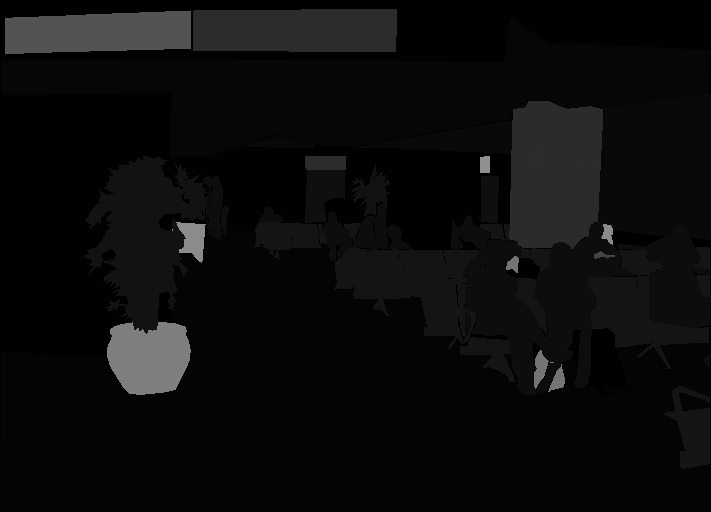

In [31]:
map = Image.open('/kaggle/working/ADE20k_toy_dataset/annotations/training/ADE_train_00000002.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'windowpane', 'person', 'door', 'plant', 'chair', 'column', 'signboard', 'book', 'light', 'bag', 'pot', 'ashcan', 'monitor', None]


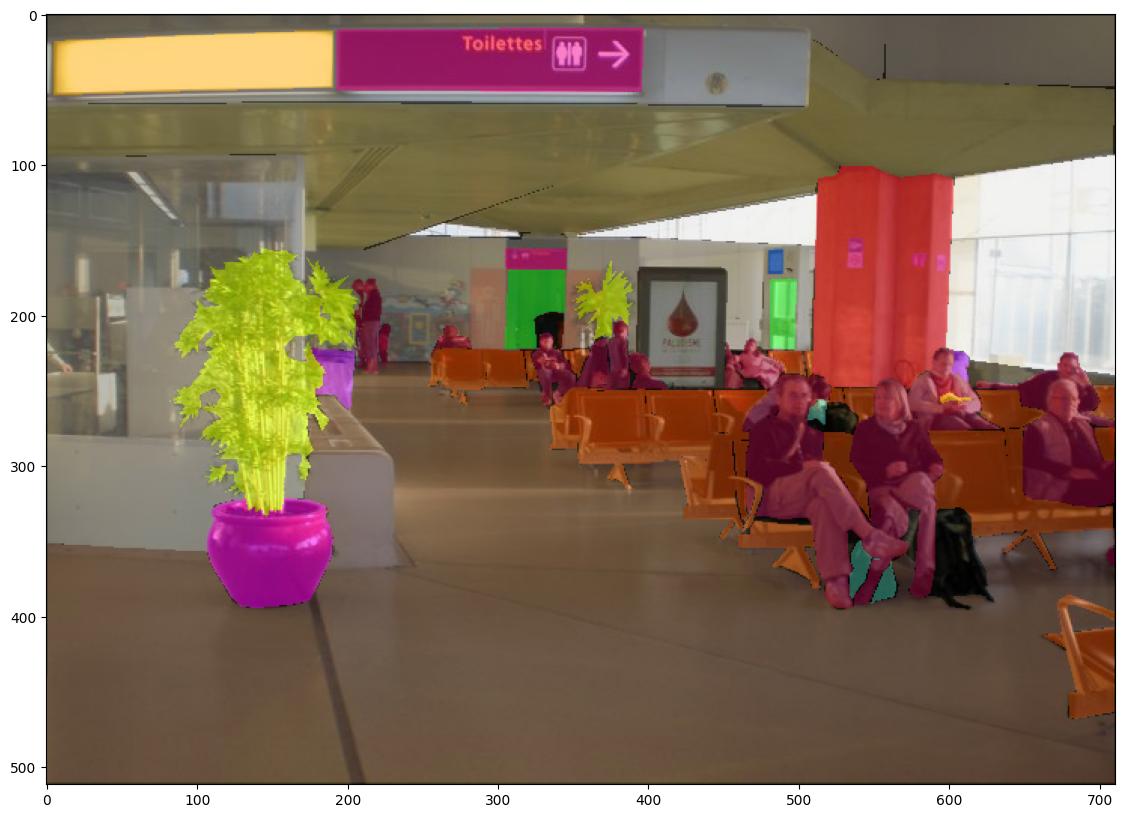

In [32]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [33]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

In [34]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [35]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.5563137772688288
mean_accuracy 0.5998258554604633
overall_accuracy 0.9190670198177033
---------------------
per-category metrics:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,IoU,accuracy
wall,0.808976,0.948356
building,NaN,NaN
sky,NaN,NaN
floor,0.961424,0.987487
tree,NaN,NaN
...,...,...
shower,NaN,NaN
radiator,NaN,NaN
glass,NaN,NaN
clock,NaN,NaN


In [36]:
metric_table

{'wall': [0.8089756361534394, 0.9483556568001269],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.9614240095721289, 0.9874870321602426],
 'tree': [nan, nan],
 'ceiling': [0.936043176168115, 0.9755519631507851],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.9206136680613668, 0.9414650844363305],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.6888533333333333, 0.8606841403820524],
 'earth': [nan, nan],
 'door': [0.25062240663900415, 0.2533557046979866],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.7578779693884619, 0.8621287323721737],
 'curtain': [nan, nan],
 'chair': [0.654482974070603, 0.7059304900356215],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [nan, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [nan, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [nan, nan],
 'fence': [nan, nan],
 'desk': [nan, nan],
 